# Filtering and Translation


__Content creators:__  Mahdi Anvari, Sadegh Rizi, Amirhossein Norouzi

**University of Tehran, Department of Biotechnology**

In [1]:
import pandas as pd
import numpy as np
from Bio.Seq import Seq

In [2]:
tblastn_output = pd.read_csv("tblastn_result.out",sep='\t', header=None)

tblastn_output.columns = [
    'query id', 'subject id', '% identity', 'alignment length', 'mismatches', 'gap opens',
    'q. start', 'q. end', 's. start', 's. end', 'e-value', 'bit score'
]

In [3]:
tblastn_output.head()

,query id,subject id,% identity,alignment length,mismatches,gap opens,q. start,q. end,s. start,s. end,e-value,bit score
0,pir||A44594,k141_107880,48.691,191,85,5,6,187,586,26,8.890000e-50,166.0
1,pir||A44594,k141_3922551,47.120,191,88,5,6,187,177,737,3.020000e-47,161.0
2,pir||A44594,k141_3299547,46.316,190,89,5,7,187,779,222,1.430000e-46,160.0
3,pir||A44594,k141_7053183,45.789,190,90,5,7,187,632,75,9.290000e-46,158.0
4,pir||A44594,k141_3016448,47.027,185,89,4,11,188,142,690,2.060000e-45,155.0


In [4]:
print(tblastn_output.shape)

(381439, 12)


We need to merge the tblastn output file with the contigs file. We require the contig lengths for filtering and the contig sequences for the translation step.

In [5]:
def read_contig_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.read().splitlines()
    
    contigs = []
    for i in range(0, len(lines), 2):
        header = lines[i]
        sequence = lines[i + 1]
        header_parts = header.split()
        subject_id = header_parts[0][1:]
        flag = header_parts[1].split('=')[1]
        multi = header_parts[2].split('=')[1]
        length = header_parts[3].split('=')[1]
        
        contigs.append((subject_id, flag, multi, length, sequence))
    
    df = pd.DataFrame(contigs, columns=['subject_id', 'flag', 'multi', 'len', 'sequence'])
    return df

contig_file_path = 'y5.final.contigs/y5.final.contigs.fa'
contig_df = read_contig_file(contig_file_path)


In [6]:
contig_df.head()

,subject_id,flag,multi,len,sequence
0,k141_4482744,0,6.0769,206,AAACAGGGCGGGCAACAATTCCTATCCCCGGAACAATATCTGAAAC...
1,k141_1600980,1,3.0000,315,TGACGCTTGGCAAATTCGTCGGCAAGCACGCAATGGCGGCAGTCGG...
2,k141_7684702,0,1.0000,329,AAGCGGCGGCGCAGAGCTTCTTGGTCTATAGTCATATACAGTTCCG...
3,k141_640392,1,2.0000,356,CTCAGCGTTTCCGAGGTGTTCTTGATGGCTTCGATACGTCGCTTCA...
4,k141_2241372,0,1.0000,363,GAGAAGGTGCGCAACATCAACTCCACCCTGCTCAACTACAAGGACA...


In [7]:
print(contig_df.shape)

(5452840, 5)


In [8]:
contig_df_subset = contig_df[['subject_id', 'len', 'sequence']]

In [9]:
contig_df_subset.head()

,subject_id,len,sequence
0,k141_4482744,206,AAACAGGGCGGGCAACAATTCCTATCCCCGGAACAATATCTGAAAC...
1,k141_1600980,315,TGACGCTTGGCAAATTCGTCGGCAAGCACGCAATGGCGGCAGTCGG...
2,k141_7684702,329,AAGCGGCGGCGCAGAGCTTCTTGGTCTATAGTCATATACAGTTCCG...
3,k141_640392,356,CTCAGCGTTTCCGAGGTGTTCTTGATGGCTTCGATACGTCGCTTCA...
4,k141_2241372,363,GAGAAGGTGCGCAACATCAACTCCACCCTGCTCAACTACAAGGACA...


In [10]:
print(contig_df_subset.shape)

(5452840, 3)


In [11]:
merged_df = pd.merge(tblastn_output, contig_df_subset, left_on='subject id', right_on='subject_id', how='left')
merged_df.drop(columns='subject_id', inplace=True)

In [12]:
merged_df.rename(columns={'len': 'contig_len', 'sequence': 'contig_sequence'}, inplace=True)

In [13]:
merged_df.head()

,query id,subject id,% identity,alignment length,mismatches,gap opens,q. start,q. end,s. start,s. end,e-value,bit score,contig_len,contig_sequence
0,pir||A44594,k141_107880,48.691,191,85,5,6,187,586,26,8.890000e-50,166.0,751,AACCACCGGTAATGTCATTTTGGTTAACAGTAGCAGAGCCAGAGCT...
1,pir||A44594,k141_3922551,47.120,191,88,5,6,187,177,737,3.020000e-47,161.0,854,TATATATTAATTAAAAAAAATAAATTTAATTTAATTATTATTTTAA...
2,pir||A44594,k141_3299547,46.316,190,89,5,7,187,779,222,1.430000e-46,160.0,1028,CAATCCCCAAAAAAATTCCTTAAAACAGTATTTTAAATTATAAATT...
3,pir||A44594,k141_7053183,45.789,190,90,5,7,187,632,75,9.290000e-46,158.0,933,GATTAAAAGTTTAATAATTAATGAATATTTTTAATAAAAATTATTG...
4,pir||A44594,k141_3016448,47.027,185,89,4,11,188,142,690,2.060000e-45,155.0,771,GATATAAATATAATAAAAAATTTTAAAAAATAAATAAAAATGAGAA...


In [14]:
print(merged_df.shape)

(381439, 14)


In [15]:
merged_df['contig_len'] = pd.to_numeric(merged_df['contig_len'], errors='coerce')

In [16]:
has_nan = merged_df.isna().values.any()
print(f"Any NaNs in the merged dataFrame: {has_nan}")

Any NaNs in the merged dataFrame: False


In [17]:
del contig_df
del contig_df_subset
del tblastn_output

In [18]:
import gc
gc.collect()

90

## Filtering ##

Now, it’s time to filter out sequences based on criteria such as identity, e-value, contig length, and alignment length.

In [19]:
filtered_df = merged_df[(merged_df['% identity'] > 70)&
                        (merged_df['e-value'] < 1e-20)&
                        (merged_df['contig_len'] < 2000)&
                        (merged_df['alignment length'] > 100)&
                        (merged_df['contig_len'] * 0.7 < merged_df['alignment length'] * 3)]

In [20]:
filtered_df.head()

,query id,subject id,% identity,alignment length,mismatches,gap opens,q. start,q. end,s. start,s. end,e-value,bit score,contig_len,contig_sequence
448,AAA21848.1,k141_6776299,86.364,198,26,1,295,491,594,1,1.450000e-111,338.0,650,ACCCATCTTCATGCCGAGTTCTTCCCACTTCTTGAAGTGAGCAGTG...
450,AAA21848.1,k141_7367989,84.925,199,29,1,212,409,599,3,5.490000e-92,287.0,599,TATTCTACGAGCGGATCAACCGTCCAACCATAGATACCGATGTAGT...
452,AAA21848.1,k141_7411831,87.135,171,21,1,195,364,3,515,9.610000e-75,241.0,515,TCTATCAGTATTTCAGCGTCCGTGACAGGCCGCGTGATTGTGGTAC...
1014,AAA23287.1,k141_2912295,71.939,196,55,0,55,250,591,4,1.250000e-100,296.0,608,GCTGGCAGAACCACTACTCTGGTAGCCTTCGATATTTAATGCAGCC...
1027,AAA23287.1,k141_2679568,73.653,167,44,0,58,224,501,1,2.140000e-89,269.0,695,CCAAGCCTTAAAATGCTCGGTTACGGAAATGGTGCCGCTGGTACGC...


In [21]:
print(filtered_df.shape)

(2339, 14)


## Translation ##

Before translation, we must determine the reading frame of the contig. For sense contigs, we need to know their alignment start point, while for antisense contigs, we must also consider the contig length in addition to the alignment start point.

In [23]:
filtered_df['frame'] = np.where(
    filtered_df['s. end'] > filtered_df['s. start'],
    ((filtered_df['s. start'] - 1) % 3) + 1,
    (((filtered_df['contig_len'] - filtered_df['s. start']) % 3) * (-1)) - 1
)

C:\Users\M\AppData\Local\Temp\ipykernel_10888\3053742987.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['frame'] = np.where(


In [24]:
filtered_df.head()

,query id,subject id,% identity,alignment length,mismatches,gap opens,q. start,q. end,s. start,s. end,e-value,bit score,contig_len,contig_sequence,frame
448,AAA21848.1,k141_6776299,86.364,198,26,1,295,491,594,1,1.450000e-111,338.0,650,ACCCATCTTCATGCCGAGTTCTTCCCACTTCTTGAAGTGAGCAGTG...,-3
450,AAA21848.1,k141_7367989,84.925,199,29,1,212,409,599,3,5.490000e-92,287.0,599,TATTCTACGAGCGGATCAACCGTCCAACCATAGATACCGATGTAGT...,-1
452,AAA21848.1,k141_7411831,87.135,171,21,1,195,364,3,515,9.610000e-75,241.0,515,TCTATCAGTATTTCAGCGTCCGTGACAGGCCGCGTGATTGTGGTAC...,3
1014,AAA23287.1,k141_2912295,71.939,196,55,0,55,250,591,4,1.250000e-100,296.0,608,GCTGGCAGAACCACTACTCTGGTAGCCTTCGATATTTAATGCAGCC...,-3
1027,AAA23287.1,k141_2679568,73.653,167,44,0,58,224,501,1,2.140000e-89,269.0,695,CCAAGCCTTAAAATGCTCGGTTACGGAAATGGTGCCGCTGGTACGC...,-3


In [25]:
def translate_sequence(nucleotide_seq, frame):
    if frame > 0:
        translated_seq = Seq(nucleotide_seq[frame-1:]).translate()
    else:
        reverse_complement_seq = str(Seq(nucleotide_seq).reverse_complement())
        frame = frame * (-1)
        translated_seq = Seq(reverse_complement_seq[frame-1:]).translate()
        
    if '*' not in str(translated_seq):
        return str(translated_seq)
    else:
        return ' '

In [26]:
filtered_df['amino_acid_sequence'] = filtered_df.apply(
    lambda row: translate_sequence(row['contig_sequence'], row['frame']), axis=1
)

C:\Users\M\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\Seq.py:3482: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(
C:\Users\M\AppData\Local\Temp\ipykernel_10888\3345418976.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['amino_acid_sequence'] = filtered_df.apply(


In [27]:
filtered_df.head()

,query id,subject id,% identity,alignment length,mismatches,gap opens,q. start,q. end,s. start,s. end,e-value,bit score,contig_len,contig_sequence,frame,amino_acid_sequence
448,AAA21848.1,k141_6776299,86.364,198,26,1,295,491,594,1,1.450000e-111,338.0,650,ACCCATCTTCATGCCGAGTTCTTCCCACTTCTTGAAGTGAGCAGTG...,-3,AATAKSSSSKGSAAVSGTIDACKDEMGHQGDSKTTQGQNNSSVTGN...
450,AAA21848.1,k141_7367989,84.925,199,29,1,212,409,599,3,5.490000e-92,287.0,599,TATTCTACGAGCGGATCAACCGTCCAACCATAGATACCGATGTAGT...,-1,ISEHMRQWEKMGMTMGKLYEAKVLGEAGNVNGEVRNGRMDFPHAKV...
452,AAA21848.1,k141_7411831,87.135,171,21,1,195,364,3,515,9.610000e-75,241.0,515,TCTATCAGTATTTCAGCGTCCGTGACAGGCCGCGTGATTGTGGTAC...,3,YQYFSVRDRPRDCGTINISEHMRQWEKMGMTMGKLYEAKVLGEAGN...
1014,AAA23287.1,k141_2912295,71.939,196,55,0,55,250,591,4,1.250000e-100,296.0,608,GCTGGCAGAACCACTACTCTGGTAGCCTTCGATATTTAATGCAGCC...,-3,LVPSMTVKAADTIYNNKTGNQDGYDYELWKDTGNTSMTLNAGGTFD...
1027,AAA23287.1,k141_2679568,73.653,167,44,0,58,224,501,1,2.140000e-89,269.0,695,CCAAGCCTTAAAATGCTCGGTTACGGAAATGGTGCCGCTGGTACGC...,-3,


In [28]:
print(filtered_df.shape)

(2339, 16)


In [29]:
filtered_df = filtered_df[filtered_df['amino_acid_sequence'].str.len() > 5]

In [30]:
filtered_df.head()

,query id,subject id,% identity,alignment length,mismatches,gap opens,q. start,q. end,s. start,s. end,e-value,bit score,contig_len,contig_sequence,frame,amino_acid_sequence
448,AAA21848.1,k141_6776299,86.364,198,26,1,295,491,594,1,1.450000e-111,338.0,650,ACCCATCTTCATGCCGAGTTCTTCCCACTTCTTGAAGTGAGCAGTG...,-3,AATAKSSSSKGSAAVSGTIDACKDEMGHQGDSKTTQGQNNSSVTGN...
450,AAA21848.1,k141_7367989,84.925,199,29,1,212,409,599,3,5.490000e-92,287.0,599,TATTCTACGAGCGGATCAACCGTCCAACCATAGATACCGATGTAGT...,-1,ISEHMRQWEKMGMTMGKLYEAKVLGEAGNVNGEVRNGRMDFPHAKV...
452,AAA21848.1,k141_7411831,87.135,171,21,1,195,364,3,515,9.610000e-75,241.0,515,TCTATCAGTATTTCAGCGTCCGTGACAGGCCGCGTGATTGTGGTAC...,3,YQYFSVRDRPRDCGTINISEHMRQWEKMGMTMGKLYEAKVLGEAGN...
1014,AAA23287.1,k141_2912295,71.939,196,55,0,55,250,591,4,1.250000e-100,296.0,608,GCTGGCAGAACCACTACTCTGGTAGCCTTCGATATTTAATGCAGCC...,-3,LVPSMTVKAADTIYNNKTGNQDGYDYELWKDTGNTSMTLNAGGTFD...
1869,AAA85198.1,k141_5257166,75.595,168,40,1,57,223,504,1,4.560000e-89,281.0,567,AAAATGCTTGGATACAGATATAGTTCCCTCCAGCTTTGTACCGCTG...,-1,PTPENSVNVAQETEPAAEALEFTENITDTADGYDYELWKDEGDTLF...


In [31]:
print(filtered_df.shape)

(1844, 16)


In [32]:
filtered_df.to_excel('filtered_output.xlsx', index=False, engine='openpyxl')

In [33]:
def dataframe_to_fasta(df, fasta_filename):
    with open(fasta_filename, 'w') as file:
        for _, row in df.iterrows():
            header = f">{row['subject id']}"
            sequence = row['amino_acid_sequence']
            file.write(f"{header}\n{sequence}\n")


In [34]:
dataframe_to_fasta(filtered_df, 'filtered_output.fasta')

Before proceeding with further downstream analysis, let’s first examine the distribution of our filtered protein sequences.

In [35]:
filtered_df['amino_acid_sequence'].str.len()

448       216
450       199
452       171
1014      202
1869      189
         ... 
374294    174
374295    165
374296    179
374299    167
374313    166
Name: amino_acid_sequence, Length: 1844, dtype: int64

In [36]:
(filtered_df['amino_acid_sequence'].str.len()).describe()

count    1844.000000
mean      184.382321
std        71.591851
min       100.000000
25%       132.000000
50%       167.000000
75%       211.000000
max       642.000000
Name: amino_acid_sequence, dtype: float64

<AxesSubplot: >

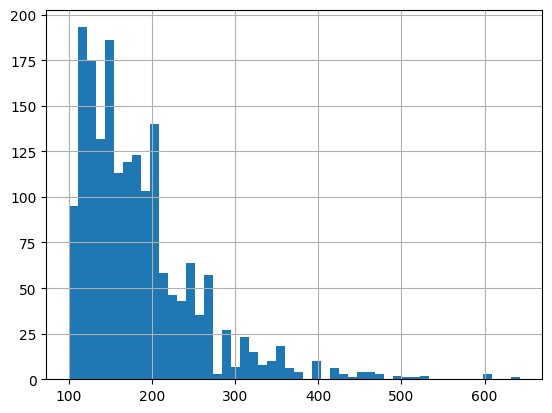

In [37]:
(filtered_df['amino_acid_sequence'].str.len()).hist(bins=50)